# **1- Showing The DataSet Contents :** 

In [ ]:
import os

BASE = "/kaggle/input/combined-ds/archive (42)/Data"

testcases_path = os.path.join(BASE, "TestCases")
artworks_path = os.path.join(BASE, "Artworks")

print("TestCases:", len(os.listdir(testcases_path)))
print("Artworks:", len(os.listdir(artworks_path)))


# **2- Printing Sample From the TestCase and Artwork Data :**

Sample TestCase Image:


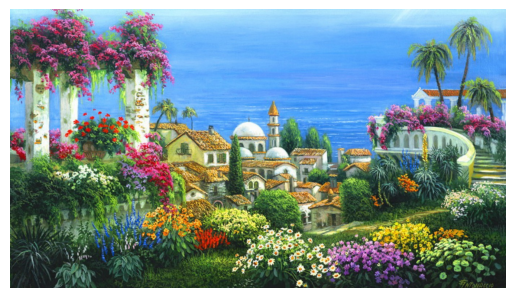

Sample Artwork Image:


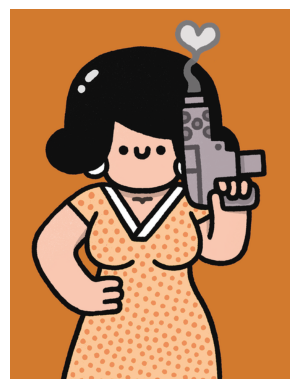

In [8]:
from PIL import Image
import matplotlib.pyplot as plt

def show_image(path):
    img = Image.open(path)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

# Example previews
sample_test = os.path.join(testcases_path, os.listdir(testcases_path)[0])
sample_art = os.path.join(artworks_path, os.listdir(artworks_path)[0])

print("Sample TestCase Image:")
show_image(sample_test)

print("Sample Artwork Image:")
show_image(sample_art)


In [ ]:
!pip install -q protobuf==3.20.3
import os
os._exit(00)   # Restart the Python runtime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 5.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, bu

# **3- Spliting And Training The Data usint Autoencoder and Decoder :**

In [6]:
# ===========================================================
# 0) REPRODUCIBILITY SETTINGS
# ===========================================================
import os
import random
import numpy as np
import tensorflow as tf
import hashlib

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
tf.config.experimental.enable_op_determinism()

def sorted_walk(path):
    for root, dirs, files in os.walk(path):
        dirs.sort()
        files.sort()
        yield root, dirs, files


# ===========================================================
# 1) IMPORTS
# ===========================================================
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split


# ===========================================================
# 2) LOAD + PREPROCESS IMAGES — UNIQUE ONLY
# ===========================================================
def load_unique_images(data_dir, img_size=(256, 256)):
    images = []
    seen_hashes = set()

    for root, dirs, files in sorted_walk(data_dir):

        # FIXED: avoid recursion only for nested "/Data" folders
        if root.lower().endswith("/data/data"):
            continue

        for filename in files:
            if filename.lower().endswith(('.png','.jpg','.jpeg','.bmp','.tiff')):
                try:
                    img = Image.open(os.path.join(root, filename)).convert("RGB")
                    img = img.resize(img_size, Image.LANCZOS)
                    arr = np.array(img, dtype="uint8")

                    # Duplicate removal using SHA256 (safer than MD5)
                    h = hashlib.sha256(arr.tobytes()).hexdigest()
                    if h in seen_hashes:
                        continue

                    seen_hashes.add(h)
                    images.append(arr.astype("float32") / 255.0)

                except Exception as e:
                    print("Error loading:", filename, e)

    print("Loaded unique images:", len(images))
    return np.array(images, dtype="float32")


# >>> DATASET PATH <<<
DATASET_ROOT = "/kaggle/input/combined-ds/archive (42)/Data"
dataset_images = load_unique_images(DATASET_ROOT)

# ===========================================================
# 2.1+ 2.2 SPLIT → 80% TRAIN, 10% VALIDATION & 10% TEST
# ===========================================================
train_full, temp = train_test_split(
    dataset_images,
    test_size=0.20,  # 20% of data will be split into validation and test
    random_state=42,
    shuffle=True
)

val_clean, test_clean = train_test_split(
    temp,
    test_size=0.50,  # 50% of the remaining 20% for test -> 10% total for test
    random_state=42,
    shuffle=True
)

print("Train-Full:", len(train_full), "Validation:", len(val_clean), "Test:", len(test_clean))






# ===========================================================
# 2.3) AUGMENTATION (TRAIN + VAL ONLY)
# ===========================================================
SCALE_VALUES = [0.85, 0.95, 1.00, 1.05, 1.15, 0.90]
BRIGHTNESS_VALUES = [0.90, 1.10, 1.00, 1.05, 0.95, 1.15]
ROTATE_VALUES = [0, 1, 2, 3]

def create_augmented_dataset(images):
    augmented = []
    idx = 0

    for img in images:
        # Original
        augmented.append(img)

        # Flip
        augmented.append(np.fliplr(img))

        # Scale
        s = SCALE_VALUES[idx % len(SCALE_VALUES)]
        augmented.append(np.clip(img * s, 0, 1))

        # Brightness
        b = BRIGHTNESS_VALUES[idx % len(BRIGHTNESS_VALUES)]
        augmented.append(np.clip(img * b, 0, 1))

        # Rotation
        k = ROTATE_VALUES[idx % len(ROTATE_VALUES)]
        augmented.append(np.rot90(img, k=k))

        idx += 1

    return np.array(augmented, dtype="float32")

train_aug = create_augmented_dataset(train_imgs)
val_aug   = create_augmented_dataset(val_imgs)

print("Augmented Train:", len(train_aug))
print("Augmented Val:", len(val_aug))


# ===========================================================
# 2.4) ADD NOISE (TRAIN + VAL ONLY)
# ===========================================================
noise_factor = 0.05
rng = np.random.default_rng(42)

train_noisy = np.clip(train_aug + rng.normal(0, noise_factor, train_aug.shape), 0, 1)
val_noisy   = np.clip(val_aug   + rng.normal(0, noise_factor, val_aug.shape),   0, 1)

test_clean = np.array(test_clean, dtype="float32")  # REMAINS CLEAN


# ===========================================================
# 2.5) AUTOENCODER MODEL
# ===========================================================
def pixel_accuracy(y_true, y_pred):
    threshold = 0.10
    correct = K.less_equal(K.abs(y_true - y_pred), threshold)
    return K.mean(K.cast(correct, K.floatx()))

def build_autoencoder(input_shape=(256,256,3)):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(2, padding="same")(x)

    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2, padding="same")(x)

    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2, padding="same")(x)

    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)

    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)

    outputs = layers.Conv2D(3, 3, activation="sigmoid", padding="same")(x)
    return models.Model(inputs, outputs)

autoencoder = build_autoencoder()

autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="mse",
    metrics=[pixel_accuracy]
)


# ===========================================================
# 2.6) TRAIN AUTOENCODER
# ===========================================================
early_stop = tf.keras.callbacks.EarlyStopping(
    patience=15, restore_best_weights=True, monitor="val_loss"
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    patience=5, factor=0.5, min_lr=1e-6, monitor="val_loss", verbose=1
)

history = autoencoder.fit(
    train_noisy, train_aug,
    validation_data=(val_noisy, val_aug),
    epochs=100,
    batch_size=4,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

print("Final Val Accuracy:", history.history["val_pixel_accuracy"][-1])


# ===========================================================
# 2.7) TEST EVALUATION — CLEAN ONLY
# ===========================================================
test_loss, test_acc = autoencoder.evaluate(test_clean, test_clean, verbose=0)
print("Final Test Accuracy:", test_acc)


Loaded unique images: 130
Train-Full: 104 Validation: 13 Test: 13
Augmented Train: 360
Augmented Val: 95
Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0753 - pixel_accuracy: 0.2371

2025-12-13 13:00:53.681816: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 116ms/step - loss: 0.0751 - pixel_accuracy: 0.2380 - val_loss: 0.0376 - val_pixel_accuracy: 0.5006 - learning_rate: 1.0000e-04
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - loss: 0.0280 - pixel_accuracy: 0.5223 - val_loss: 0.0307 - val_pixel_accuracy: 0.5196 - learning_rate: 1.0000e-04
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - loss: 0.0190 - pixel_accuracy: 0.6428 - val_loss: 0.0177 - val_pixel_accuracy: 0.7096 - learning_rate: 1.0000e-04
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - loss: 0.0134 - pixel_accuracy: 0.7548 - val_loss: 0.0156 - val_pixel_accuracy: 0.7442 - learning_rate: 1.0000e-04
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - loss: 0.0119 - pixel_accuracy: 0.7816 - val_loss: 0.0137 - val_pixel_accuracy: 0.7729 - learning_rate: 1.0000e-04
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 0.0113 - pixel_accuracy: 0.7891 - val_loss: 0.0133 - val_pixel_accuracy: 0.7779 - learning_rate: 1.0000

2025-12-13 13:16:31.987373: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


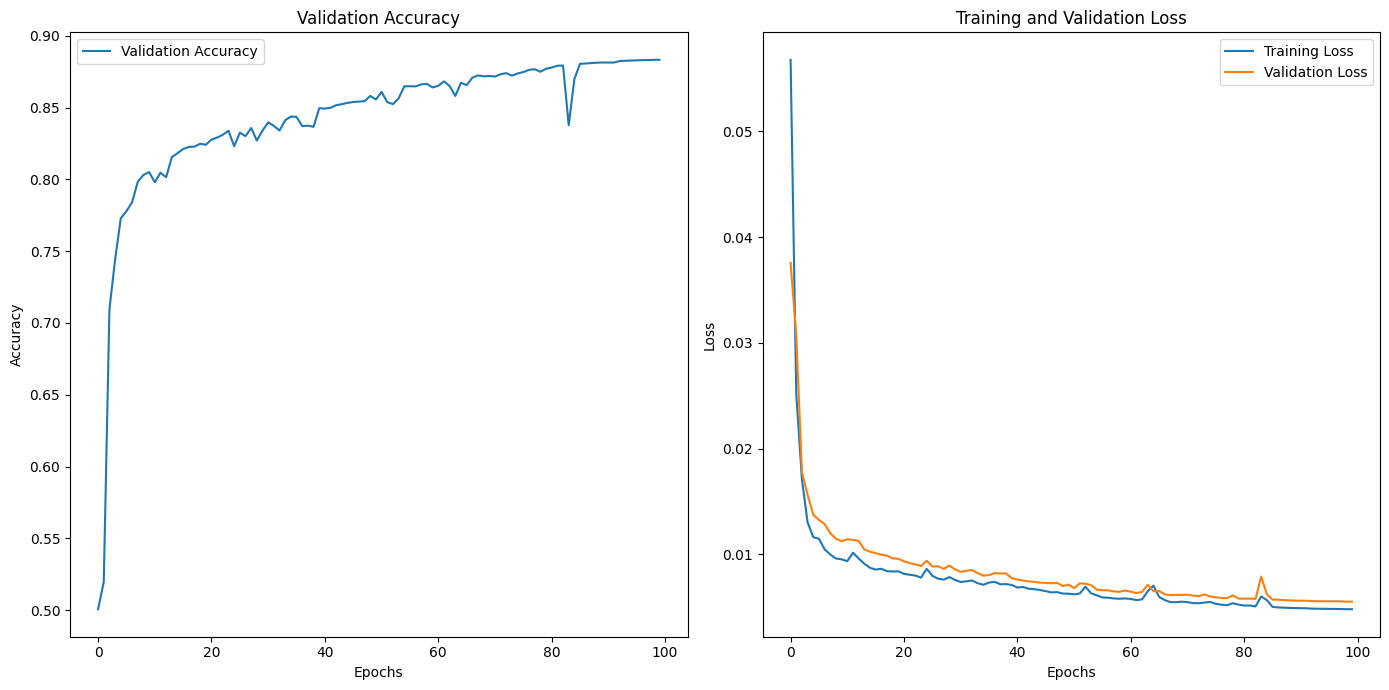

Test Accuracy: 0.8175663352012634


In [8]:
# ===========================================================
# 3.0) PLOTTING THE METRICS (Validation and Test Accuracy)
# ===========================================================
# Plot the training and validation accuracy (if available)
plt.figure(figsize=(14, 7))

# Plot Validation Accuracy (Pixel Accuracy)
plt.subplot(1, 2, 1)
plt.plot(history.history['val_pixel_accuracy'], label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot the Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Display Test Accuracy (from evaluation step)
print("Test Accuracy:", test_acc)



# **4- Cleaning The Input Images Using The Trained Autoencoder And Style Transfer with VGG19**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


2025-12-13 13:57:24.024764: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Step 0 | Loss = 8.2210e+19
Step 100 | Loss = 1.5030e+19
Step 200 | Loss = 6.6480e+18
Step 300 | Loss = 3.2835e+18
Step 400 | Loss = 1.6100e+18
Step 500 | Loss = 7.8969e+17
Step 600 | Loss = 4.0375e+17
Step 700 | Loss = 2.2366e+17
Step 800 | Loss = 1.3740e+17
Step 900 | Loss = 9.3564e+16
Step 1000 | Loss = 6.9160e+16
Step 1100 | Loss = 5.4454e+16
Step 1200 | Loss = 4.5887e+16
Step 1300 | Loss = 4.4820e+16
Step 1400 | Loss = 3.2459e+16


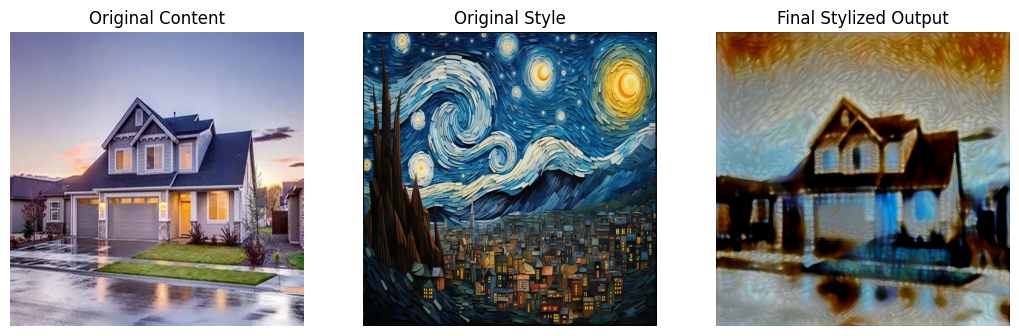

In [15]:
# ===========================================================
# 3.1) CLEAN IMAGES USING TRAINED AUTOENCODER 
# ===========================================================

def clean_image_hd(path, target_size=(1024, 1024)):
    # Load original full-resolution image
    img_orig = Image.open(path).convert("RGB")
    img_orig = img_orig.resize(target_size, Image.LANCZOS)

    # Create 256px input for autoencoder
    img_256 = img_orig.resize((256, 256), Image.LANCZOS)
    arr = np.array(img_256).astype("float32") / 255.0
    arr = np.expand_dims(arr, axis=0)

    # Autoencoder cleaning (denoising and enhancement)
    cleaned_256 = autoencoder.predict(arr)[0]
    cleaned_256 = (cleaned_256 * 255).astype(np.uint8)

    # Upscale AE output back to HD
    cleaned_hd = Image.fromarray(cleaned_256).resize(target_size, Image.LANCZOS)

    # Blend HD original edges + AE cleaned texture for enhanced clarity
    blended = Image.blend(img_orig, cleaned_hd, alpha=0.75)

    return img_orig, blended


content_path = "/kaggle/input/home-image/homeimg.webp"
style_path   = "/kaggle/input/style-image/il_1588xN.5689132816_1672.avif"

# Clean the content and style images using the trained autoencoder
orig_content, clean_content = clean_image_hd(content_path)
orig_style, clean_style = clean_image_hd(style_path)

# ===========================================================
# 4) PREPARE INPUTS FOR VGG19 
# ===========================================================

def preprocess_vgg(image):
    arr = np.array(image).astype("float32")
    arr = tf.keras.applications.vgg19.preprocess_input(arr)
    return arr[np.newaxis]

# Prepare the cleaned content and style images for VGG19 (used in NST)
content_img  = preprocess_vgg(clean_content)
style_img    = preprocess_vgg(clean_style)


# ===========================================================
# 5) STYLE TRANSFER WITH VGG19 
# ===========================================================

vgg = tf.keras.applications.VGG19(include_top=False, weights="imagenet")
vgg.trainable = False

content_layers = ["block4_conv2"]
style_layers = [
    "block1_conv1", "block2_conv1", "block3_conv1",
    "block4_conv1", "block5_conv1"
]

# Extract features from selected layers
outputs = [vgg.get_layer(l).output for l in (style_layers + content_layers)]
feature_model = tf.keras.Model(vgg.input, outputs)

# Gram matrix function for calculating style loss
def gram_matrix(t):
    t = tf.squeeze(t)
    c = int(t.shape[-1])
    t = tf.reshape(t, [-1, c])
    return tf.matmul(t, t, transpose_a=True)

# Extract the style and content features
def extract_features(img):
    out = feature_model(img)
    return out[:len(style_layers)], out[len(style_layers):]

# Extract style + content reference features
style_feats, _ = extract_features(style_img)
_, content_feats = extract_features(content_img)

# Initialize generated image as the cleaned content image
generated = tf.Variable(content_img, dtype=tf.float32)

# Define optimizer for style transfer
optimizer = tf.keras.optimizers.Adam(learning_rate=1.0)

# Define style and content loss weights
style_weight = 1e1  
content_weight = 3e2

# Optimization loop for style transfer
for i in range(1500):
    with tf.GradientTape() as tape:
        gen_style, gen_content = extract_features(generated)

        # Calculate style loss 
        s_loss = sum(tf.reduce_mean((gram_matrix(gs) - gram_matrix(ss)) ** 2)
                     for gs, ss in zip(gen_style, style_feats))

        # Calculate content loss
        c_loss = tf.reduce_mean((gen_content[0] - content_feats[0]) ** 2)

        total_loss = style_weight * s_loss + content_weight * c_loss

    grads = tape.gradient(total_loss, generated)
    optimizer.apply_gradients([(grads, generated)])
    generated.assign(tf.clip_by_value(generated, -150, 150))

    if i % 100 == 0:
        print(f"Step {i} | Loss = {total_loss.numpy():.4e}")


# ===========================================================
# 6) POST-PROCESS OUTPUT
# ===========================================================

# Deprocess the generated image (back to valid RGB range)
def deprocess(x):
    x = x.reshape((x.shape[1], x.shape[2], 3))
    x[:,:,0] += 103.939
    x[:,:,1] += 116.779
    x[:,:,2] += 123.68
    return np.clip(x, 0, 255).astype(np.uint8)

final_img = deprocess(generated.numpy())


# ===========================================================
# 7) DISPLAY ALL RESULTS SIDE-BY-SIDE
# ===========================================================

plt.figure(figsize=(22, 10))

plt.subplot(1, 5, 1)
plt.title("Original Content")
plt.imshow(orig_content)
plt.axis("off")

plt.subplot(1, 5, 2)
plt.title("Original Style")
plt.imshow(orig_style)
plt.axis("off")

plt.subplot(1, 5, 3)
plt.title("Final Stylized Output")
plt.imshow(final_img)
plt.axis("off")

plt.show()


AE Blend $\alpha = \mathbf{0.75}$: The strong reliance on the autoencoder's output ensures the style transfer is working with a cleaner, enhanced image.Steps (1500) and Learning Rate (1.0): These ensure a stable and thorough optimization process.